In [72]:
from bs4 import BeautifulSoup
import requests
from lxml.html import fromstring
import pandas as pd
import numpy as np

In [73]:
# XPATHs
containers_XPATH = '//div[@class="FeatureItem_ecFeatureItem__qK6P7"]'
data_name_XPATH = '//p[@class="Typography_ecTypographyParagraph__qt7Br Typography_ecTypographyRegular__FX_vf"]'
data_XPATH = '//p[@class="Typography_ecTypographyParagraph__qt7Br FeatureItem_ecFeatureItemValue__UUGou Typography_ecTypographyBold__cxADa"]'

In [122]:
def get_soup(url):
    r = requests.get(url)
    soup = BeautifulSoup(r.text, 'html.parser')
    return soup

def get_apt_urls(url):
    soup = get_soup(url)
    cards = soup.find_all('div', class_='ListingCard_ecListingCard__L_sk9')
    return cards

def get_apt_data(link):
    soup = get_soup(link)
    tree = fromstring(str(soup))
    # Get data containers
    containers = tree.xpath(data_XPATH)
    
    # Fill JSON with apt data
    apt = {}
    try: 
        # Get price
        apt['Preço'] = int(soup.find('strong', class_='ValueBox_ecValueBoxHeaderPrice__4kV85').text.replace('R$\xa0', '').replace('.', '').replace(',00', '').strip())
        # Get Location
        map_link = soup.find('a', class_='Imovel_ecLocationButton__uWGjZ Button_ecButton__mN8yZ Button_ecButtonThemeOutline__pfIVZ')['href']
        location = map_link.split('query=')[1]
        apt['Localização'] = location
    except Exception as e:
        print(e)
        apt['Localização'] = None

    # Fill JSON with other apt data
    for i in range(len(containers)):
        try:
            data_name = tree.xpath(data_name_XPATH)[i].text.strip()
            data = containers[i].text.replace('R$\xa0', '').replace('.', '').replace(',00', '').replace('m²', '').strip()
            # Ignore data that is not relevant
            if ('Impostos e cartório' not in data_name) and ('Financiamento' not in data_name):
                # Convert numeric data to int
                if data_name not in ['Localização', 'Andar do imóvel', 'Próximo ao metrô']:
                    data = int(data)
                # Store data in JSON
                apt[data_name] = data

        except Exception as e:
            print(e)
            apt[data_name] = None
    return apt

In [123]:
apts = []

pages = 7

# Iterate over pages
for page in range(pages):
    url = 'https://emcasa.com/imoveis/rj/rio-de-janeiro/flamengo/apartamento?pagina='+str(page)+'&lc=-43.1757021,%20-22.936822,%20Flamengo,%20Rio%20de%20Janeiro%20-%20RJ&precoMaximo=800000'

    cards = get_apt_urls(url)
    # Iterate over apartments
    for card in cards:
        link =  card.find('a', class_='ListingCard_ecListingContainer__CBKdQ')['href']
        apt = get_apt_data('https://emcasa.com' + link)
        apts.append(apt)

{'Preço': 750000, 'Localização': '-22.936537,-43.1749054', 'Área útil': 64, 'Total de quartos': 2, 'Suítes': 0, 'Banheiros sociais': 1, 'Andar do imóvel': 'Andar intermediário', 'Elevador': 2, 'IPTU anual': 2200, 'Valor do condomínio': 2300, 'Vagas de garagem': 1, 'Próximo ao metrô': 'Sim', 'Valor do m²': 37500}
{'Preço': 790000, 'Localização': '-22.9376888,-43.1757686', 'Área útil': 90, 'Total de quartos': 3, 'Suítes': 0, 'Banheiros sociais': 1, 'Andar do imóvel': 'Andar baixo', 'Elevador': 2, 'IPTU anual': 2523, 'Valor do condomínio': 1365, 'Vagas de garagem': 0, 'Próximo ao metrô': 'Sim', 'Valor do m²': 39500}
{'Preço': 480000, 'Localização': '-22.9359772,-43.1770135', 'Área útil': 52, 'Total de quartos': 2, 'Suítes': 2, 'Banheiros sociais': 0, 'Andar do imóvel': 'Andar baixo', 'Elevador': 1, 'IPTU anual': 1200, 'Valor do condomínio': 800, 'Vagas de garagem': 0, 'Próximo ao metrô': 'Sim', 'Valor do m²': 24000}
{'Preço': 580000, 'Localização': '-22.9364571,-43.17764459999999', 'Área 

In [126]:
apts_df = pd.DataFrame(apts)
apts_df = apts_df[apts_df['Preço'].notnull()]
apts_df['Banheiros'] = apts_df['Banheiros sociais'] + apts_df['Suítes']

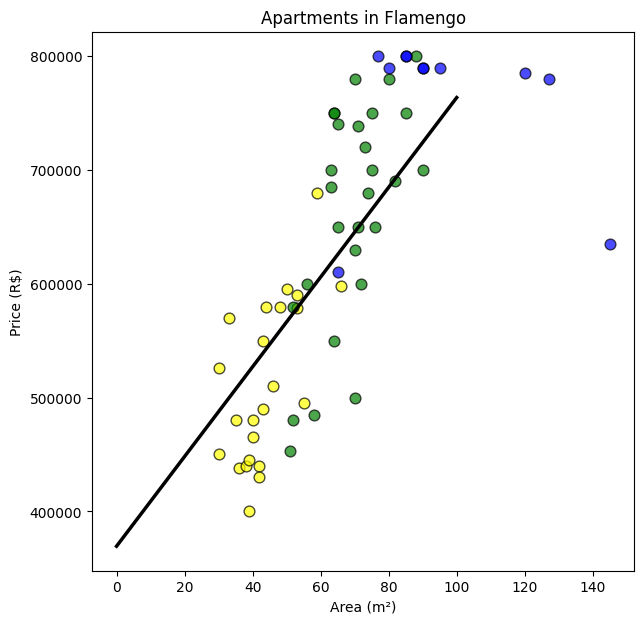

In [125]:
import matplotlib.pyplot as plt
import numpy as np

one_room = apts_df[apts_df['Total de quartos'] == 1]
two_rooms = apts_df[apts_df['Total de quartos'] == 2]
three_rooms = apts_df[apts_df['Total de quartos'] == 3]


fig, ax = plt.subplots(figsize = (7, 7))

ax.scatter(one_room['Área útil'], one_room['Preço'], s=60, alpha=0.7, c='yellow', edgecolors='black', linewidths=1, label='1 quarto')
ax.scatter(two_rooms['Área útil'], two_rooms['Preço'], s=60, alpha=0.7, c='green', edgecolors='black', linewidths=1, label='2 quartos')
ax.scatter(three_rooms['Área útil'], three_rooms['Preço'], s=60, alpha=0.7, c='blue', edgecolors='black', linewidths=1, label='3 quartos')

# Linear Regression to get the line
b, a = np.polyfit(apts_df['Área útil'], apts_df['Preço'], deg=1)
xseq = np.linspace(0, 100, num=1000)
# Plot regression line
ax.plot(xseq, a + b * xseq, color="k", lw=2.5)

plt.title('Apartments in Flamengo')
plt.xlabel("Area (m²)")
plt.ylabel("Price (R$)")

plt.show()

In [128]:
from sklearn.model_selection import train_test_split

predictors = apts_df[['Área útil', 'Total de quartos', 'Banheiros']]
target = apts_df['Preço']

X_train, X_test, y_train, y_test = train_test_split(predictors, target, test_size=0.3, random_state=40)

In [129]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

_preds_df = pd.DataFrame(dict(observed=y_test, predicted=y_pred))
_preds_df.head()

,observed,predicted
41,490000.0,517191.229647
60,740000.0,643443.679179
67,650000.0,634442.931634
4,685000.0,626880.805419
39,440000.0,513410.166540


In [130]:
from sklearn.metrics import mean_squared_error

print('Score: {}'.format(lr.score(X_test, y_test)))
print('MSE: {}'.format(mean_squared_error(y_test, y_pred)))
print('Intercept: {}'.format(lr.intercept_))
print('Coefficients: {}'.format(lr.coef_))

Score: 0.1393993138720121
MSE: 10338835592.468008
Intercept: 311536.45486002916
Coefficients: [ 3781.06310736 34068.31362498  9000.74754538]


In [131]:
area = 56
bedrooms = 3
bathrooms = 2

pred_price = lr.intercept_ + area * lr.coef_[0] + bedrooms * lr.coef_[1] + bathrooms * lr.coef_[2]
print(pred_price)

643482.4248379102
